In [3]:
import numpy as np
from matplotlib import pyplot as plt


In [4]:
class Agent:
    def choose_action(self,state):
        action = 0
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.Q[state])
        return action
class DoubleLearningAgent:
    def choose_action(self,state):
        action = 0
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.Q1[state]+self.Q2[state])
        return action

In [5]:
class SarsaAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        target = reward + self.gamma * self.Q[next_state,next_action]
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error
    

In [6]:
class QLearningAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        target = reward + self.gamma * np.max(self.Q[next_state,:])
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error

In [7]:
class ExpectedSarsa(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        expected_q = 0
        for i in range(self.num_actions):
            expected_q += self.Q[next_state][i] * (1/self.num_actions)
        target = reward + self.gamma * expected_q    
        
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error

In [8]:
class DoubleQLearningAgent(DoubleLearningAgent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q1 = np.zeros((num_states,num_actions))
        self.Q2 = np.zeros((num_states,num_actions))

        self.action_space = action_space
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        if np.random.uniform(0,1) < .5:
            prediction = self.Q1[prev_state,prev_action]
            target = reward + gamma*self.Q2[next_state,np.argmax(self.Q1[next_state,:])]
            error = target - prediction
            self.Q1[prev_state,prev_action] += self.alpha * error
        else:
            prediction = self.Q2[prev_state,prev_action]
            target = reward + gamma*self.Q1[next_state,np.argmax(self.Q2[next_state,:])]
            error = target - prediction
            self.Q2[prev_state,prev_action] += self.alpha * error

In [9]:
import gym
import math
env = gym.make('CliffWalking-v0') 

epsilon = .1
total_episodes = 500
max_steps = 500
gamma = 1
alpha = .5

MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.2

sarsaAgent = SarsaAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
qAgent = QLearningAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
expectedSarsa = ExpectedSarsa(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
doubleQLearning = DoubleQLearningAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
agents = [sarsaAgent,qAgent,expectedSarsa,doubleQLearning]

alphas = [.25,.5,.75,1]

results = {
    'SarsaAgent': [],
    'QLearningAgent': [],
    'ExpectedSarsa': [],
    'DoubleQLearningAgent': []
}

for alpha in alphas: 
    episodeReward = 0
    totalReward = {
        'SarsaAgent':[],
        'QLearningAgent':[],
        'ExpectedSarsa': [],
        'DoubleQLearningAgent': []
    }
    for agent in agents:
        agent.alpha = alpha
        for episode in range(total_episodes):
            t = 0
            state = env.reset()
            action = agent.choose_action(state)
            episode_reward = 0
            while t < max_steps:
                next_state,reward,done,info = env.step(action)     
                next_action = agent.choose_action(next_state)

                agent.update(state,action,reward,next_state,next_action)

                state = next_state
                action = next_action

                t += 1
                episode_reward += reward

                if done:
                    break
            totalReward[type(agent).__name__].append(episode_reward)

    results['SarsaAgent'].append(np.mean(totalReward['SarsaAgent']))
    results['QLearningAgent'].append(np.mean(totalReward['QLearningAgent']))
    results['ExpectedSarsa'].append(np.mean(totalReward['ExpectedSarsa']))
    results['DoubleQLearningAgent'].append(np.mean(totalReward['DoubleQLearningAgent']))
env.close() 

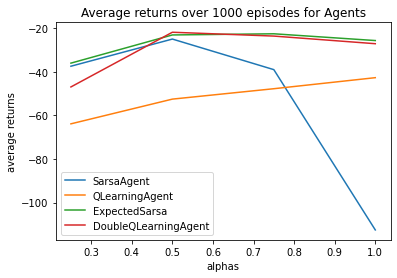

In [10]:
for agent in agents:
    plt.plot(alphas,results[type(agent).__name__],label=type(agent).__name__)
plt.xlabel("alphas")
plt.ylabel("average returns")
plt.title("Average returns over 1000 episodes for Agents")
plt.legend()
plt.show()

- Sarsa can only perform well for small alphas
- Expected Sarsa can safely set alpha = 1 without suffering any degredation of performance
- TD algos (Q-Learning) usesa a maximization operation, which leads to a maximization bias. For instance, consider q(s,a) = 0; Q(s,a) is uncertain and has a positive bias. Most of true values is zero, but the max Q(s,a) is positive, hence we have a positive bias. The maximization bias occurs because we use the same samples to determine the maximizng action and its value. We solve this over time by using 2 diff Q funcs Q1,Q2 to determine max action and value and then switching them overtime. In this CliffWalking example the DoubleQLearningAgent performs significantly better than its QLearningAgent counterpart.

In [11]:
for agent in agents:
    print(type(agent).__name__,results[type(agent).__name__])

SarsaAgent [-37.434, -24.974, -39.002, -112.526]
QLearningAgent [-63.862, -52.524, -47.752, -42.688]
ExpectedSarsa [-36.016, -23.088, -22.554, -25.654]
DoubleQLearningAgent [-46.938, -21.846, -23.606, -27.104]


In [12]:
class BoxObservationSarsaAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,Q,action_space):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = action_space
        self.Q = Q
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state+(prev_action,)]
        target = reward + self.gamma * self.Q[next_state+(next_action,)]
        error = target - prediction
        self.Q[prev_state+(prev_action,)] += self.alpha * error
        
class BoxObservationQLearningAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,Q,action_space):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = action_space
        self.Q = Q
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state+(prev_action,)]
        target = reward + self.gamma * np.amax(self.Q[next_state])
        error = target - prediction
        self.Q[prev_state+(prev_action,)] += self.alpha * error

class BoxObservationDoubleQLearningAgent(DoubleLearningAgent):
    def __init__(self,epsilon,alpha,gamma,Q1,Q2,action_space):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = action_space
        
        self.Q1 = Q1
        self.Q2 = Q2

        self.action_space = action_space
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        if np.random.uniform(0,1) < .5:
            prediction = self.Q1[prev_state+(prev_action,)]
            target = reward + self.gamma*self.Q2[next_state+(np.argmax(self.Q1[next_state]),)]
            error = target - prediction
            self.Q1[prev_state+(prev_action,)] += self.alpha * error
        else:
            prediction = self.Q2[prev_state+(prev_action,)]
            target = reward + self.gamma*self.Q1[next_state+(np.argmax(self.Q2[next_state]),)]
            error = target - prediction
            self.Q2[prev_state+(prev_action,)] += self.alpha * error

In [13]:
import gym
import math

env = gym.make('CartPole-v0')
NUM_BUCKETS = (1, 1, 6, 3)  # (x, x', theta, theta')
NUM_ACTIONS = env.action_space.n # (left, right)
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
# Manually setting bounds (needed for the x_dot and theta_dot)
#STATE_BOUNDS[0] = [STATE_BOUNDS[0][0]/2, STATE_BOUNDS[0][1]/2]
STATE_BOUNDS[1] = [-0.5, 0.5]
#STATE_BOUNDS[2] = [STATE_BOUNDS[2][0]/2, STATE_BOUNDS[2][0]/2]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]

## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.2

# Defining the simulation related constants
NUM_EPISODES = 500
MAX_T = 500
STREAK_TO_END = 100
SOLVED_T = 199

NUM_TRIALS = 1
DEBUG = False

def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.5, 1.0 - math.log10((t+1)/25)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


boxQAgent = BoxObservationQLearningAgent(1,1,1,np.zeros(NUM_BUCKETS + (NUM_ACTIONS,)),env.action_space)
boxDoubleQAgent = BoxObservationDoubleQLearningAgent(1,1,1,np.zeros(NUM_BUCKETS + (NUM_ACTIONS,)),np.zeros(NUM_BUCKETS + (NUM_ACTIONS,)),env.action_space)
boxSarsa = BoxObservationSarsaAgent(1,1,1,np.zeros(NUM_BUCKETS + (NUM_ACTIONS,)),env.action_space)
agents = [boxSarsa,boxQAgent,boxDoubleQAgent]

episdoesRequiredToSolve = {
    'BoxObservationSarsaAgent': [],
    'BoxObservationQLearningAgent': [],
    'BoxObservationDoubleQLearningAgent':[]
}
for agent in agents:
    for trial in range(NUM_TRIALS):
        agent.alpha = get_learning_rate(0)
        agent.epsilon = get_explore_rate(0)
        agent.gamma = 0.999  # since the world is unchanging

        num_streaks = 0

        for episode in range(NUM_EPISODES):
            obv = env.reset()

            state = state_to_bucket(obv)

            for t in range(MAX_T):

                action = agent.choose_action(state)

                obv,reward,done,_ = env.step(action)

                next_state = state_to_bucket(obv)

                next_action = agent.choose_action(next_state)

                agent.update(state,action,reward,next_state,next_action)

                state = next_state

                if done:
                    if DEBUG:
                        print("Episode %d finished after %f time steps" % (episode, t))
                    if t >= SOLVED_T:
                        num_streaks += 1
                    else:
                        num_streaks = 0
                    break
            if num_streaks > STREAK_TO_END:
                episdoesRequiredToSolve[type(agent).__name__].append(episode)
                break
            elif episode == NUM_EPISODES:
                episdoesRequiredToSolve[type(agent).__name__].append(NUM_EPISODES)
            agent.epsilon = get_explore_rate(episode)
            agent.alpha = get_learning_rate(episode)
env.close()

In [14]:
for agent in agents:
    print(type(agent).__name__,episdoesRequiredToSolve[type(agent).__name__])

BoxObservationSarsaAgent [339]
BoxObservationQLearningAgent [286]
BoxObservationDoubleQLearningAgent [263]
